<a href="https://colab.research.google.com/github/seunghee0518/AI_python/blob/main/%5BBASELINE%5D_EfficientNet_b0%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8_imagesize224_epoch100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 셋 전처리 및 시각화

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# 코랩에서 이미지 출력하기
#from google.colab.patches import cv2_imshow
# imgfile = '/gdrive/MyDrive/cropStudy/sample.JPG'
# img = cv2.imread(imgfile, cv2.IMREAD_COLOR)
#이미지 출력하기( ver. colab)
# cv2_imshow(a)

Mounted at /content/drive


In [2]:
!pip install timm

     |████████████████████████████████| 431 kB 16.0 MB/s 


In [3]:
# 공모전 기본 코드
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time
import gc

device = torch.device('cuda')

## 이미지 경로
train_png = sorted(glob('/content/drive/Othercomputers/내 MacBook Pro/open/train/*.png'))
#test_png = sorted(glob('/content/drive/Othercomputers/내 MacBook Pro/open/train/*.png'))

train_y = pd.read_csv("/content/drive/Othercomputers/내 MacBook Pro/open/train_df.csv")

train_labels = train_y["label"]

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]

def img_load(path):
    img = cv2.imread(path)[:,:,::-1].astype('float32') # [:,:,::-1] -> BGR -> RGB 변경
    img = cv2.resize(img, (224, 224))
    img = img/255
    return img

# for i, m in enumerate(tqdm(train_png)):
#   if i == 0:
#     train_imgs = img_load(m).copy()
#     del m
#     gc.collect()
#   else:
#     train_imgs = np.concatenate([train_imgs, img_load(m)], 0)
#     del m
#     gc.collect()
train_imgs = [img_load(m) for m in tqdm(train_png)]
#test_imgs = [img_load(n) for n in tqdm(test_png)]

100%|██████████| 4277/4277 [06:54<00:00, 10.32it/s]


In [8]:
np.shape(train_imgs) # 예상 shape : (4277, 512, 512, 3)

(4277, 224, 224, 3)

In [9]:
np.save('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/train_imgs_224', train_imgs)

In [ ]:
# ## 이미지 가져와서 넘파이 배열 생성
# import re
# import cv2
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# import pandas as pd
# import numpy as np
# import gc

# ## 주어진 train_df에 각 레이블마다 원-핫 인코딩값을 생성할 인덱스 부여
# train_df = pd.read_csv('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/train_df.csv')
# final_train88_df = train_df.copy()
# label_lst = final_train88_df.label.unique().tolist()
# label_lst.sort()
# one_hot_label = pd.DataFrame(label_lst, columns = {'label'})
# one_hot_label['one_hot_label'] = one_hot_label.index.tolist()
# one_hot_label

# final_train88_df = pd.merge(final_train88_df, one_hot_label, how = 'left', on = 'label')
# final_train88_df

# # 학습 파일 기본 경로 지정 및 넘파이 배열로 변환
# # 넘파일 배열을 생성할 레이블의 one_hot_label값 [0 ~ 87] / df > one_hot_label 참조
# image_dir = '/content/drive/Othercomputers/내 MacBook Pro/open/train'
# num_total_label = 88 # 레이블 총 개수
# one_hot_label = [x for x in range(88)]

# img_rows = 512
# img_cols = 512

# X = [] # 입력 데이터
# Y = [] # 정답값

# ## 이미지 배열 파일 생성
# for index, row in tqdm(final_train88_df.iterrows(), total = len(final_train88_df)) : 
#   filename = row['file_name']
#   label_idx = row['one_hot_label']
#   # img_label : Y 배열에 들어갈 원-핫 인코딩된 정답값
#   img_label = [0 for i in range(num_total_label)]
#   img_label[label_idx] = 1

#   img = cv2.imread(f'{image_dir}/{filename}')#.astype('float32')
#   img = cv2.resize(img, (img_rows,img_cols))#, fx=img_w/img.shape[1], fy=img_h/img.shape[0])
#   X.append(img/256)
#   Y.append(img_label)

# X = np.array(X)
# Y = np.array(Y)

# x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=1234)

# ## 안쓰는 변수 비우기 : 램관리
# del X, Y
# gc.collect()

In [6]:
# ## 저장된 이미지 불러오기
# import cv2 
# import numpy as np 
# import pandas as pd
# import keras
# import math

# import matplotlib.pyplot as plt
# import os # miscellaneous operating system interfaces
# import shutil # high-level file operations
# from glob import glob
# from tqdm import tqdm
# import re
# from sklearn.model_selection import train_test_split
# import random
# import cv2
# from PIL import Image
# import PIL.ImageOps    
# from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import array_to_img, img_to_array, load_img
# import gc
# imageset_save_dir = '/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/imageset'
# imagset512 = glob(f'{imageset_save_dir}/*type0_512*')
# imagset512.sort()

# for i in tqdm(range(len(imagset512))):
#   path = imagset512[i]
#   if i == 0:
#     xy_savez_load = np.load(path)
#     X = xy_savez_load['x'].astype('float32') # 약 15gb
#     Y = xy_savez_load['y'].astype('float32')
#     xy_savez_load.close()
#   else:
#     xy_savez_load = np.load(path)
#     each_X = xy_savez_load['x'].astype('float32')
#     each_Y = xy_savez_load['y'].astype('float32')
#     xy_savez_load.close()


#     X = np.concatenate([X, each_X], 0)
#     Y = np.concatenate([Y, each_Y], 0)
#     try:
#       del each_X, each_Y
#       gc.collect()
#     except: pass

# print('X 차원 : ', np.shape(X))
# print('Y 차원 : ', np.shape(Y))

# x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=1234)
# del X, Y
# gc.collect()

  1%|          | 1/88 [00:00<00:27,  3.17it/s]Exception ignored in: <function NpzFile.__del__ at 0x7f24b486b0e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 224, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 219, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected
100%|██████████| 88/88 [06:47<00:00,  4.63s/it]


X 차원 :  (4277, 512, 512, 3)
Y 차원 :  (4277, 88)


In [4]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            augmentation = random.randint(0,2)
            if augmentation==1:
                img = img[::-1].copy()
            elif augmentation==2:
                img = img[:,::-1].copy()
        img = transforms.ToTensor()(img)
        if self.mode=='test':
            pass
        
        label = self.labels[idx]
        return img, label

class Custom_dataset_2(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        # if self.mode=='train':
        #     augmentation = random.randint(0,2)
        #     if augmentation==1:
        #         img = img[::-1].copy()
        #     elif augmentation==2:
        #         img = img[:,::-1].copy()
        img = transforms.ToTensor()(img)
        if self.mode=='test':
            pass
        
        label = self.labels[idx]
        return img, label
    
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=88)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [4]:
# ## 저장된 넘파이배열
# # 공모전 기본 코드
# import warnings
# warnings.filterwarnings('ignore')

# from glob import glob
# import pandas as pd
# import numpy as np 
# from tqdm import tqdm
# import cv2

# import os
# import timm
# import random

# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn
# import torchvision.transforms as transforms
# from sklearn.metrics import f1_score, accuracy_score
# import time

#train_imgs = np.load('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/train_imgs.npy')

In [5]:
batch_size = 32
epochs = 100

# Train
train_dataset = Custom_dataset_2(np.array(train_imgs), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# # Test
# test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
# test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 

best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


epoch : 1/100    time : 27s/2680s
TRAIN    loss : 1.00512    f1 : 0.24234
epoch : 2/100    time : 26s/2587s
TRAIN    loss : 0.54737    f1 : 0.37586
epoch : 3/100    time : 26s/2549s
TRAIN    loss : 0.38658    f1 : 0.53500
epoch : 4/100    time : 28s/2660s
TRAIN    loss : 0.32205    f1 : 0.59923
epoch : 5/100    time : 26s/2499s
TRAIN    loss : 0.29178    f1 : 0.63599
epoch : 6/100    time : 27s/2509s
TRAIN    loss : 0.22484    f1 : 0.70578
epoch : 7/100    time : 26s/2454s
TRAIN    loss : 0.17718    f1 : 0.77005
epoch : 8/100    time : 26s/2428s
TRAIN    loss : 0.13255    f1 : 0.82845
epoch : 9/100    time : 30s/2695s
TRAIN    loss : 0.13888    f1 : 0.85453
epoch : 10/100    time : 26s/2376s
TRAIN    loss : 0.12658    f1 : 0.87199
epoch : 11/100    time : 27s/2359s
TRAIN    loss : 0.09489    f1 : 0.88341
epoch : 12/100    time : 26s/2320s
TRAIN    loss : 0.05213    f1 : 0.94714
epoch : 13/100    time : 26s/2293s
TRAIN    loss : 0.05233    f1 : 0.94921
epoch : 14/100    time : 26s/2268s

In [ ]:
# ## 모델추론 : 램부족으로 수행 X
# model.eval()
# f_pred = []

# with torch.no_grad():
#     for batch in (test_loader):
#         x = torch.tensor(batch[0], dtype = torch.float32, device = device)
#         with torch.cuda.amp.autocast():
#             pred = model(x)
#         f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

# label_decoder = {val:key for key, val in label_unique.items()}

# f_result = [label_decoder[result] for result in f_pred]

In [ ]:
# submission = pd.read_csv("/content/drive/Othercomputers/내 MacBook Pro/open/sample_submission.csv")

# submission["label"] = f_result

# submission

### 여기부터 안쓰는 코드

In [ ]:

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

# 훈련데이터 세트 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
np.shape(x)

(569, 30)

In [ ]:
np.shape(y_test)

(114,)

In [ ]:
yy_test

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1])

In [ ]:
y

(569,)

In [ ]:
# 학습 파일 기본 경로 지정 및 분류할 클래스 
import re
import cv2
from sklearn.model_selection import train_test_split

# base_dir : /content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open
train_base_dir = base_dir + '/train_label_88/'

categories = train_label_unique
categories.sort() # 알파벳 순으로 정렬
num_classes = len(categories)

In [ ]:
import pandas as pd
## 주어진 train_df에 각 레이블마다 원핫인코딩값을 생성할 인덱스 부여
final_train88_df = train_df.copy()
label_lst = final_train88_df.label.unique().tolist()
label_lst.sort()
one_hot_label = pd.DataFrame(label_lst, columns = {'label'})
one_hot_label['one_hot_label'] = one_hot_label.index.tolist()
one_hot_label

final_train88_df = pd.merge(final_train88_df, one_hot_label, how = 'left', on = 'label')
final_train88_df

,index,file_name,class,state,label,one_hot_label
0,0,10000.png,transistor,good,transistor-good,72
1,1,10001.png,capsule,good,capsule-good,15
2,2,10002.png,transistor,good,transistor-good,72
3,3,10003.png,wood,good,wood-good,76
4,4,10004.png,bottle,good,bottle-good,3
...,...,...,...,...,...,...
4272,4272,14272.png,transistor,good,transistor-good,72
4273,4273,14273.png,transistor,good,transistor-good,72
4274,4274,14274.png,grid,good,grid-good,28
4275,4275,14275.png,zipper,good,zipper-good,84


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
112

In [ ]:
import re
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc

## 주어진 train_df에 각 레이블마다 원-핫인코딩값을 생성할 인덱스 부여
train_df = pd.read_csv('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/train_df.csv')
final_train88_df = train_df.copy()
label_lst = final_train88_df.label.unique().tolist()
label_lst.sort()
one_hot_label = pd.DataFrame(label_lst, columns = {'label'})
one_hot_label['one_hot_label'] = one_hot_label.index.tolist()
one_hot_label

final_train88_df = pd.merge(final_train88_df, one_hot_label, how = 'left', on = 'label')
final_train88_df

# 학습 파일 기본 경로 지정 및 넘파이 배열로 변환
# 넘파일 배열을 생성할 레이블의 one_hot_label값 [0 ~ 87] / df > one_hot_label 참조
image_dir = '/content/drive/Othercomputers/내 MacBook Pro/open/train'
num_total_label = 88 # 레이블 총 개수
one_hot_label = [x for x in range(88)]

img_rows = 512
img_cols = 512

X = [] # 입력 데이터
Y = [] # 정답값

## 이미지 배열 파일 생성
for index, row in tqdm(final_train88_df.iterrows(), total = len(final_train88_df)) : 
  filename = row['file_name']
  label_idx = row['one_hot_label']
  # img_label : Y 배열에 들어갈 원-핫 인코딩된 정답값
  img_label = [0 for i in range(num_total_label)]
  img_label[label_idx] = 1

  img = cv2.imread(f'{image_dir}/{filename}').astype('float32')
  img = cv2.resize(img, (img_rows,img_cols))#, fx=img_w/img.shape[1], fy=img_h/img.shape[0])
  X.append(img/256)
  Y.append(img_label)

X = np.array(X)
Y = np.array(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=1234)

## 안쓰는 변수 비우기 : 램관리
del X, Y
gc.collect()

100%|██████████| 4277/4277 [01:59<00:00, 35.90it/s]


15

In [ ]:
x_train

array([[[[0.4250781 , 0.4250781 , 0.4250781 ],
         [0.37980467, 0.37980467, 0.37980467],
         [0.23007812, 0.23007812, 0.23007812],
         ...,
         [0.42089844, 0.42089844, 0.42089844],
         [0.501836  , 0.501836  , 0.501836  ],
         [0.7121484 , 0.7121484 , 0.7121484 ]],

        [[0.33839858, 0.33839858, 0.33839858],
         [0.39253944, 0.39253944, 0.39253944],
         [0.5798828 , 0.5798828 , 0.5798828 ],
         ...,
         [0.2873047 , 0.2873047 , 0.2873047 ],
         [0.27617216, 0.27617216, 0.27617216],
         [0.31433606, 0.31433606, 0.31433606]],

        [[0.4734375 , 0.4734375 , 0.4734375 ],
         [0.54648435, 0.54648435, 0.54648435],
         [0.5205078 , 0.5205078 , 0.5205078 ],
         ...,
         [0.6611328 , 0.6611328 , 0.6611328 ],
         [0.71738315, 0.71738315, 0.71738315],
         [0.6976564 , 0.6976564 , 0.6976564 ]],

        ...,

        [[0.19882812, 0.19882812, 0.19882812],
         [0.2775392 , 0.2775392 , 0.2775392 ]

In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')


## 안쓰는 변수 비우기 : 램관리
del X, Y
gc.collect()

82

In [ ]:
np.shape(x_train)

(2993, 10, 10, 3)

In [ ]:
# 저장한 배열로 학습 / 검증 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, Y) # test_size=0.25(default), shuffle : 셔플여부설정 (default = True)

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

1. Import libraries

In [ ]:
import cv2 
import numpy as np 
import pandas as pd
import keras
import math
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.layers.core import Layer # !pip install dependencies # 설치 안됨
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils 
from tensorflow.keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import os # miscellaneous operating system interfaces
import shutil # high-level file operations
from glob import glob
from tqdm import tqdm

import re
from sklearn.model_selection import train_test_split

In [ ]:
#!pip install keras
print(keras.__version__)

2.8.0


In [ ]:
base_dir = '/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open'
train_dir = '/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/train'
test_dir = '/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/test'

train_df = pd.read_csv('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/train_df.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/test_df.csv')

In [ ]:
len(os.listdir(train_dir)), len(os.listdir(test_dir))

(4277, 2154)

In [ ]:
## train 데이터 개수 및 레이블 개수
train_label = train_df.label.tolist()
train_label_unique = list(set(train_label))
print(len(train_label), len(train_label_unique))

4277 88


In [ ]:
# ## 88개 레이블 폴더 생성
# os.mkdir(base_dir+f'train_label_88')
# for dir in train_label_unique:
#   os.mkdir(base_dir+f'train_label_88/{dir}')

In [ ]:
# import shutil
# from tqdm import tqdm

# for i in tqdm(range(len(train_df))):
#   file_name = train_df.loc[i, 'file_name']
#   label     = train_df.loc[i, 'label']

#   source = train_dir + f'/{file_name}'
#   destination = base_dir + f'train_label_88/{label}/{file_name}'
#   shutil.copyfile(source, destination) # 이동이 아닌 카피로 실행함
#   # shutil.move(file_source, file_destination) # 이동하는 코드

100%|██████████| 4277/4277 [23:58<00:00,  2.97it/s]


In [ ]:
# # 분리된 이미지 파일 전체 개수 확인
# all_folder = glob(base_dir + 'train_label_88/*')
# all_img_cnt = 0
# all_img_path = []
# for folder in tqdm(all_folder, total = len(all_folder)):
#   img_list = glob(folder + '/*')
#   all_img_path += img_list
#   img_cnt = len(img_list)
#   all_img_cnt += img_cnt

100%|██████████| 90/90 [00:08<00:00, 10.40it/s]


In [ ]:
# print('분리된 이미지 파일 총 개수 : ', all_img_cnt)

분리된 이미지 파일 총 개수 :  4277


## 이미지 파일 로딩 + float array 변환 + 전처리

In [ ]:
# from keras.preprocessing import image

# def preprocess_img(img_path, target_size):
#   img = image.load_img(img_path, target_size = (target_size, target_size))
#   img_tensor = image.img_to_array(img)
#   img_tensor = np.expand_dims(img_tensor, axis = 0) # 차원 추가
#   img_tensor /= 255. # [0, 1] 범위로 표준화
#   return img_tensor

In [ ]:
# ## 이미지 시각화(랜덤 30개만)
# import random
# n_pic = 30 # 시각화할 이미지 수
# n_col = 5 # 가로 개수
# n_row = 6 # 세로 개수

# target_size = 100
# margin = 3

# total = np.zeros((n_row * target_size + (n_row - 1) * margin, n_col * target_size + (n_col - 1) * margin, 3))

# img_seq = 0

# # 전체 중 랜덤 샘플 추출함
# sampleList = random.sample(all_img_path, n_pic)

# for i in range(n_row):
#   for j in range(n_col):
#     img_path = sampleList[img_seq]
#     img_tensor = preprocess_img(img_path, target_size)

#     h_start = i * target_size + i * margin
#     h_end   = h_start + target_size
#     v_start = j * target_size + j * margin
#     v_end   = v_start + target_size

#     total[h_start:h_end, v_start:v_end] = img_tensor[0]
#     img_seq += 1

# plt.figure(figsize = (200, 200))
# plt.imshow(total)
# plt.show()

## 이미지 파일 -> 학습 데이터로 변경

In [ ]:
base_dir + '/train_label_88/'

'/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open/train_label_88/'

In [ ]:
# 학습 파일 기본 경로 지정 및 분류할 클래스 
import re
import cv2
from sklearn.model_selection import train_test_split

# base_dir : /content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open
train_base_dir = base_dir + '/train_label_88/'

categories = train_label_unique
categories.sort() # 알파벳 순으로 정렬
num_classes = len(categories)

In [ ]:
import gc
del X, Y
gc.collect()

454

In [ ]:
# 학습 파일 기본 경로 지정 및 분류할 클래스 
import re
import cv2
from sklearn.model_selection import train_test_split

# base_dir : /content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/open
train_base_dir = base_dir + '/train_label_88/'

categories = train_label_unique
categories.sort() # 알파벳 순으로 정렬
num_classes = len(categories)

# 이미지 사이즈 변경 : 
img_rows = 1024
img_cols = 1024

X = [] # 입력 데이터
Y = [] # 정답값

for idx, categorie in enumerate(tqdm(categories[22:33])):
  ## label -> 원-핫 인코딩
  label = [0 for i in range(num_classes)]
  label[idx] = 1

  # 이미지 파일 경로
  image_dir = train_base_dir + categorie + '/'

  # 레이블 폴더 별로 이미지 파일 추출
  for top, dir, f in os.walk(image_dir):
    for filename in f:
      img = cv2.imread(image_dir + filename)
      img = cv2.resize(img, (img_rows,img_cols))#, fx=img_w/img.shape[1], fy=img_h/img.shape[0])
      X.append(img/256)
      Y.append(label)

# 배열 -> 넘파이 배열로 변환
X = np.array(X)
Y = np.array(Y)

# numpy 배열 save
np.savez(f"{train_base_dir}/imageset_1024*1024_3.npz", x=X, y=Y)

# # 학습 / 검증 데이터로 분리
# X_train, X_test, y_train, y_test = train_test_split(X, Y) # test_size=0.25(default)

# X_train = X_train.astype('float32')
# y_train = y_train.astype('float32')

# # numpy 배열 저장하기
# xy = (X_train, X_test, y_train, y_test)
# np.save(f"{train_base_dir}img_data.npy", xy)

100%|██████████| 11/11 [00:41<00:00,  3.76s/it]


In [ ]:
np.savez(f"{train_base_dir}/imageset_512*512_2.npz", x=X, y=Y)

In [ ]:
## 저장한 x,y. 배열 가져오기
# 배열로 불러오기
train_base_dir = base_dir + '/train_label_88/'
xy_savez_load = np.load(f"{train_base_dir}/imageset_224*224.npz")
type(xy_savez_load)
X = xy_savez_load['x']
Y = xy_savez_load['y']

In [ ]:
# 저장한 배열로 학습 / 검증 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, Y) # test_size=0.25(default), shuffle : 셔플여부설정 (default = True)

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

2. Prepare the dataset

In [ ]:
# # load_cifar10_data 전처리 코드
# num_classes = 10 # 분류할 레이블 수

# def load_cifar10_data(img_rows, img_cols):

#     # Load cifar10 training and validation sets
#     (X_train, Y_train), (X_valid, Y_valid) = #cifar10.load_data()

#     ## 데이터셋이 넘 커서 램 감당 안됨
#     X_train = X_train[:100]
#     Y_train = Y_train[:100]

#     X_valid = X_valid[:10]
#     Y_valid = Y_valid[:10]
    
#     # Resize training images
#     X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
#     X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

#     # Transform targets to keras compatible format [np_utils.to_categorical ->  Converts a class vector (integers) to binary class matrix] 
#     Y_train = np_utils.to_categorical(Y_train, num_classes)
#     Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
#     X_train = X_train.astype('float32')
#     X_valid = X_valid.astype('float32')

#     # preprocess data
#     X_train = X_train / 255.0
#     X_valid = X_valid / 255.0

#     return X_train, Y_train, X_valid, Y_valid
# X_train, y_train, X_test, y_test = load_cifar10_data(224, 224) # 이미지 사이즈를 줄임

3. Create the inception module

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    ## concatenate  : 선택한 축 방향으로 배열 연결하는 함수[3차원 일 경우 0 : 높이, 1 : 행, 2 : 열, 3 : ?]
    return output

4. Create the GoogLeNet architecture

In [ ]:
# ## 책 코드 카피 + 88레이블로 분류 위해 코드 조정
# from keras.layers.normalization.batch_normalization import BatchNormalization
# kernel_init = keras.initializers.glorot_uniform()
# bias_init = keras.initializers.Constant(value=0.2)

# input_layer = Input(shape=(224, 224, 3)) # (가로, 세로, 채널(컬러 = 3))

# ### A부분 ### 
# x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
# x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
# x = BatchNormalization()(x) # 책내용 코드 추가

# ## 합성곱층 -> 1,1풀링 : 차원축소 +  3,3 풀링
# x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
# x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
# x = BatchNormalization()(x) # 책내용 코드 추가
# x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

# ### B 부분 - 인셉션 모듈 2 + 최대풀링 + 인셉션5 + 최대풀링 + 인셉션2 + 평균 풀링
# x = inception_module(x,
#                      filters_1x1=64,
#                      filters_3x3_reduce=96,
#                      filters_3x3=128,
#                      filters_5x5_reduce=16,
#                      filters_5x5=32,
#                      filters_pool_proj=32,
#                      name='inception_3a')

# x = inception_module(x,
#                      filters_1x1=128,
#                      filters_3x3_reduce=128,
#                      filters_3x3=192,
#                      filters_5x5_reduce=32,
#                      filters_5x5=96,
#                      filters_pool_proj=64,
#                      name='inception_3b')

# x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

# x = inception_module(x,
#                      filters_1x1=192,
#                      filters_3x3_reduce=96,
#                      filters_3x3=208,
#                      filters_5x5_reduce=16,
#                      filters_5x5=48,
#                      filters_pool_proj=64,
#                      name='inception_4a')

# # 중간 분류기 제외
# # classifier_1 = AveragePooling2D((5, 5), strides=3)(x)
# # classifier_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(classifier_1)
# # classifier_1 = Flatten()(classifier_1)
# # classifier_1 = Dense(1024, activation='relu')(classifier_1)
# # classifier_1 = Dropout(0.7)(classifier_1)
# # classifier_1 = Dense(88, activation='softmax', name='auxilliary_output_1')(classifier_1) # 10

# x = inception_module(x,
#                      filters_1x1=160,
#                      filters_3x3_reduce=112,
#                      filters_3x3=224,
#                      filters_5x5_reduce=24,
#                      filters_5x5=64,
#                      filters_pool_proj=64,
#                      name='inception_4b')

# x = inception_module(x,
#                      filters_1x1=128,
#                      filters_3x3_reduce=128,
#                      filters_3x3=256,
#                      filters_5x5_reduce=24,
#                      filters_5x5=64,
#                      filters_pool_proj=64,
#                      name='inception_4c')

# x = inception_module(x,
#                      filters_1x1=112,
#                      filters_3x3_reduce=144,
#                      filters_3x3=288,
#                      filters_5x5_reduce=32,
#                      filters_5x5=64,
#                      filters_pool_proj=64,
#                      name='inception_4d')
# # 중간 분류기 제외
# # classifier_2 = AveragePooling2D((5, 5), strides=3)(x)
# # classifier_2 = Conv2D(128, (1, 1), padding='same', activation='relu')(classifier_2)
# # classifier_2 = Flatten()(classifier_2)
# # classifier_2 = Dense(1024, activation='relu')(classifier_2)
# # classifier_2 = Dropout(0.7)(classifier_2)
# # classifier_2 = Dense(88, activation='softmax', name='auxilliary_output_2')(classifier_2) # 10

# x = inception_module(x,
#                      filters_1x1=256,
#                      filters_3x3_reduce=160,
#                      filters_3x3=320,
#                      filters_5x5_reduce=32,
#                      filters_5x5=128,
#                      filters_pool_proj=128,
#                      name='inception_4e')

# x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

# x = inception_module(x,
#                      filters_1x1=256,
#                      filters_3x3_reduce=160,
#                      filters_3x3=320,
#                      filters_5x5_reduce=32,
#                      filters_5x5=128,
#                      filters_pool_proj=128,
#                      name='inception_5a')

# x = inception_module(x,
#                      filters_1x1=384,
#                      filters_3x3_reduce=192,
#                      filters_3x3=384,
#                      filters_5x5_reduce=48,
#                      filters_5x5=128,
#                      filters_pool_proj=128,
#                      name='inception_5b')
# ## C 부분 : 분류기 구현
# x = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid',name='avg_pool_5_3x3/1')(x)
# x = Conv2D(128, (1, 1), padding='same' activation='relu', name='conv_3_3x3/1')(x)
# x = Flatten()
# x = Dense(1024, activation='relu', name='linear')(x)
# x = Dropout(0.4)(x) # 40% 드롭아웃
# x = Dense(88, activation='softmax', name='output')(x)

# ## 모델 생성
# # GoogleNet model without the classfiers 1 and 2 
# model = Model(input_layer, [x], name='googlenet')
# ## 모델 요약
# model.summary()

In [ ]:
# ## 책 코드 카피
# from keras.layers.normalization.batch_normalization import BatchNormalization
# kernel_init = keras.initializers.glorot_uniform()
# bias_init = keras.initializers.Constant(value=0.2)

# input_layer = Input(shape=(224, 224, 3)) # (가로, 세로, 채널(컬러 = 3))

# ### A부분 ### 
# x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
# x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
# x = BatchNormalization()(x) # 책내용 코드 추가

# ## 합성곱층 -> 1,1풀링 : 차원축소 +  3,3 풀링
# x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
# x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
# x = BatchNormalization()(x) # 책내용 코드 추가
# x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

# ### B 부분 - 인셉션 모듈 2 + 최대풀링 + 인셉션5 + 최대풀링 + 인셉션2 + 평균 풀링
# x = inception_module(x,
#                      filters_1x1=64,
#                      filters_3x3_reduce=96,
#                      filters_3x3=128,
#                      filters_5x5_reduce=16,
#                      filters_5x5=32,
#                      filters_pool_proj=32,
#                      name='inception_3a')

# x = inception_module(x,
#                      filters_1x1=128,
#                      filters_3x3_reduce=128,
#                      filters_3x3=192,
#                      filters_5x5_reduce=32,
#                      filters_5x5=96,
#                      filters_pool_proj=64,
#                      name='inception_3b')

# x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

# x = inception_module(x,
#                      filters_1x1=192,
#                      filters_3x3_reduce=96,
#                      filters_3x3=208,
#                      filters_5x5_reduce=16,
#                      filters_5x5=48,
#                      filters_pool_proj=64,
#                      name='inception_4a')

# # 중간 분류기 제외
# # classifier_1 = AveragePooling2D((5, 5), strides=3)(x)
# # classifier_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(classifier_1)
# # classifier_1 = Flatten()(classifier_1)
# # classifier_1 = Dense(1024, activation='relu')(classifier_1)
# # classifier_1 = Dropout(0.7)(classifier_1)
# # classifier_1 = Dense(88, activation='softmax', name='auxilliary_output_1')(classifier_1) # 10

# x = inception_module(x,
#                      filters_1x1=160,
#                      filters_3x3_reduce=112,
#                      filters_3x3=224,
#                      filters_5x5_reduce=24,
#                      filters_5x5=64,
#                      filters_pool_proj=64,
#                      name='inception_4b')

# x = inception_module(x,
#                      filters_1x1=128,
#                      filters_3x3_reduce=128,
#                      filters_3x3=256,
#                      filters_5x5_reduce=24,
#                      filters_5x5=64,
#                      filters_pool_proj=64,
#                      name='inception_4c')

# x = inception_module(x,
#                      filters_1x1=112,
#                      filters_3x3_reduce=144,
#                      filters_3x3=288,
#                      filters_5x5_reduce=32,
#                      filters_5x5=64,
#                      filters_pool_proj=64,
#                      name='inception_4d')
# # 중간 분류기 제외
# # classifier_2 = AveragePooling2D((5, 5), strides=3)(x)
# # classifier_2 = Conv2D(128, (1, 1), padding='same', activation='relu')(classifier_2)
# # classifier_2 = Flatten()(classifier_2)
# # classifier_2 = Dense(1024, activation='relu')(classifier_2)
# # classifier_2 = Dropout(0.7)(classifier_2)
# # classifier_2 = Dense(88, activation='softmax', name='auxilliary_output_2')(classifier_2) # 10

# x = inception_module(x,
#                      filters_1x1=256,
#                      filters_3x3_reduce=160,
#                      filters_3x3=320,
#                      filters_5x5_reduce=32,
#                      filters_5x5=128,
#                      filters_pool_proj=128,
#                      name='inception_4e')

# x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

# x = inception_module(x,
#                      filters_1x1=256,
#                      filters_3x3_reduce=160,
#                      filters_3x3=320,
#                      filters_5x5_reduce=32,
#                      filters_5x5=128,
#                      filters_pool_proj=128,
#                      name='inception_5a')

# x = inception_module(x,
#                      filters_1x1=384,
#                      filters_3x3_reduce=192,
#                      filters_3x3=384,
#                      filters_5x5_reduce=48,
#                      filters_5x5=128,
#                      filters_pool_proj=128,
#                      name='inception_5b')
# ## C 부분 : 분류기 구현
# x = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid',name='avg_pool_5_3x3/1')(x)
# x = Dropout(0.4)(x) # 40% 드롭아웃
# x = Dense(10, activation='softmax', name='output')(x)

# ## 모델 생성
# # GoogleNet model without the classfiers 1 and 2 
# model = Model(input_layer, [x], name='googlenet')
# ## 모델 요약
# model.summary()

저자 최신 코드

In [ ]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
# x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


classifier_1 = AveragePooling2D((5, 5), strides=3)(x)
classifier_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(classifier_1)
classifier_1 = Flatten()(classifier_1)
classifier_1 = Dense(1024, activation='relu')(classifier_1)
classifier_1 = Dropout(0.7)(classifier_1)
classifier_1 = Dense(88, activation='softmax', name='auxilliary_output_1')(classifier_1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


classifier_2 = AveragePooling2D((5, 5), strides=3)(x)
classifier_2 = Conv2D(128, (1, 1), padding='same', activation='relu')(classifier_2)
classifier_2 = Flatten()(classifier_2)
classifier_2 = Dense(1024, activation='relu')(classifier_2)
classifier_2 = Dropout(0.7)(classifier_2)
classifier_2 = Dense(88, activation='softmax', name='auxilliary_output_2')(classifier_2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid',name='avg_pool_5_3x3/1')(x)

x = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu', name='linear')(x)
x = Dropout(0.7)(x)
x = Dense(88, activation='softmax', name='output')(x)

In [ ]:
## 모델 생성
# GoogleNet model without the classfiers 1 and 2 
model = Model(input_layer, [x], name='googlenet')
## 모델 요약
model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                        

GoogLeNet model after adding classifiers 1 and 2

In [ ]:
model_with_classifiers = Model(input_layer, [x, classifier_1, classifier_2], name='googlenet_complete_architecture')
model_with_classifiers.summary()

Model: "googlenet_complete_architecture"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                  

compile a network with three models

In [ ]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model_with_classifiers.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
                               loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

model_with_classifiers_hist = model_with_classifiers.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), 
                                                        epochs=epochs, batch_size=256, callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


13/13 [==============================] - 77s 6s/step - loss: 6.6967 - output_loss: 4.1745 - auxilliary_output_1_loss: 4.2455 - auxilliary_output_2_loss: 4.1618 - output_accuracy: 0.0505 - auxilliary_output_1_accuracy: 0.0452 - auxilliary_output_2_accuracy: 0.0490 - val_loss: 5.4749 - val_output_loss: 3.3965 - val_auxilliary_output_1_loss: 3.4972 - val_auxilliary_output_2_loss: 3.4309 - val_output_accuracy: 0.0953 - val_auxilliary_output_1_accuracy: 0.0953 - val_auxilliary_output_2_accuracy: 0.0953 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/25
13/13 [==============================] - 70s 5s/step - loss: 5.7569 - output_loss: 3.5943 - auxilliary_output_1_loss: 3.5999 - auxilliary_output_2_loss: 3.6088 - output_accuracy: 0.0664 - auxilliary_output_1_accuracy: 0.0742 - auxilliary_output_2_accuracy: 0.0680 - val_loss: 5.3968 - val_output_loss: 3.3765 - val_auxilliary_output_1_loss: 3.3725 - val_auxilliary_output_2_loss: 3.3618 - val_output_accuracy: 

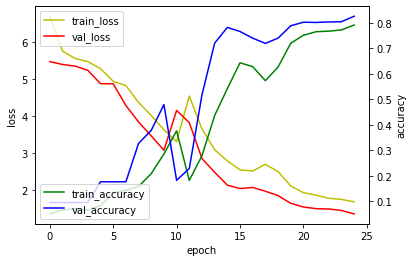

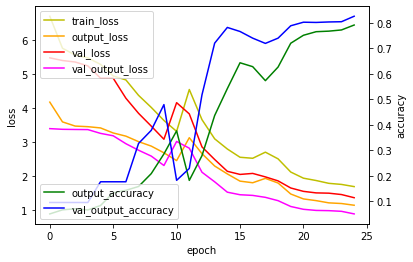

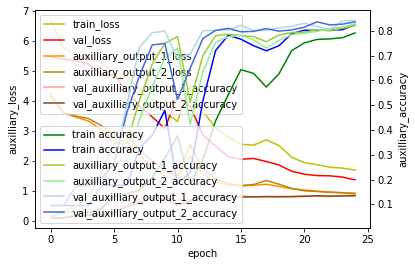

In [ ]:
# 5. 학습 과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

## 그래프1 : loss , val_loss
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

## loss 그래프
loss_ax.plot(model_with_classifiers_hist.history['loss'],'y',label='train_loss') # 노란색
loss_ax.plot(model_with_classifiers_hist.history['val_loss'],color='red' ,label='val_loss') # 빨간색

## accuracy 그래프
acc_ax.plot(model_with_classifiers_hist.history['output_accuracy'],'g',label='train_accuracy') # 초록색
acc_ax.plot(model_with_classifiers_hist.history['val_output_accuracy'],'b',label='val_accuracy') # 파란색

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

## 그래프 2 : loss , outloss, val_loss
fig, loss_ax2 = plt.subplots()
acc_ax2 = loss_ax2.twinx()

## loss 그래프
loss_ax2.plot(model_with_classifiers_hist.history['loss'],'y',label='train_loss') # 노란색
loss_ax2.plot(model_with_classifiers_hist.history['output_loss'],color='orange' ,label='output_loss') # 주황색
loss_ax2.plot(model_with_classifiers_hist.history['val_loss'],color='red' ,label='val_loss') # 빨간색
loss_ax2.plot(model_with_classifiers_hist.history['val_output_loss'],color='magenta',label='val_output_loss') # 찐핑크

## accuracy 그래프
acc_ax2.plot(model_with_classifiers_hist.history['output_accuracy'],'g',label='output_accuracy') # 초록색
acc_ax2.plot(model_with_classifiers_hist.history['val_output_accuracy'],'b',label='val_output_accuracy') # 파란색

loss_ax2.set_xlabel('epoch')
loss_ax2.set_ylabel('loss')
acc_ax2.set_ylabel('accuracy')

loss_ax2.legend(loc='upper left')
acc_ax2.legend(loc='lower left')
plt.show()

######  그래프 3 : loss&val + auxilliary loss & accuracy #####
fig2, loss_ax3 = plt.subplots()
acc_ax3 = loss_ax3.twinx()

## loss 그래프
loss_ax3.plot(model_with_classifiers_hist.history['loss'],'y',label='train_loss') # 노란색
loss_ax3.plot(model_with_classifiers_hist.history['val_loss'],color='red' ,label='val_loss') # 빨간색

loss_ax3.plot(model_with_classifiers_hist.history['auxilliary_output_1_loss'],color='darkorange',label='auxilliary_output_1_loss') # 다크 오렌지
loss_ax3.plot(model_with_classifiers_hist.history['auxilliary_output_2_loss'],color='darkgoldenrod' ,label='auxilliary_output_2_loss') # 똥색
loss_ax3.plot(model_with_classifiers_hist.history['val_auxilliary_output_1_accuracy'],color='lightsalmon' ,label='val_auxilliary_output_1_accuracy') # 연어색
loss_ax3.plot(model_with_classifiers_hist.history['val_auxilliary_output_2_accuracy'],color='saddlebrown',label='val_auxilliary_output_2_accuracy') # 고동색?

## accuracy 그래프
acc_ax3.plot(model_with_classifiers_hist.history['output_accuracy'],'g',label='train accuracy') # 초록색
acc_ax3.plot(model_with_classifiers_hist.history['val_output_accuracy'],'b',label='train accuracy') # 파란색

acc_ax3.plot(model_with_classifiers_hist.history['auxilliary_output_1_accuracy'],color = 'yellowgreen',label='auxilliary_output_1_accuracy') # 연두색
acc_ax3.plot(model_with_classifiers_hist.history['auxilliary_output_2_accuracy'],color = 'lightgreen',label='auxilliary_output_2_accuracy') # 라임색
acc_ax3.plot(model_with_classifiers_hist.history['val_auxilliary_output_1_accuracy'],color = 'lightblue',label='val_auxilliary_output_1_accuracy') # 스카이블루
acc_ax3.plot(model_with_classifiers_hist.history['val_auxilliary_output_2_accuracy'],color = 'royalblue',label='val_auxilliary_output_2_accuracy') # 로얄 블루

loss_ax3.set_xlabel('epoch')
loss_ax3.set_ylabel('auxilliary_loss')
acc_ax3.set_ylabel('auxilliary_accuracy')

loss_ax3.legend(loc='upper left')
acc_ax3.legend(loc='lower left')
plt.show()

In [ ]:
# 6. 모델 평가하기
loss_and_metrics = model_with_classifiers.evaluate(X_test,y_test,batch_size=32)
#변수명 : X_train, X_test, y_train, y_test 
print('##### Test Result #####')
print('loss : ',str(loss_and_metrics[0]))
print('Accuracy : ',str(loss_and_metrics[1]))

# 7. 모델 저장하기
from tensorflow.python.keras.models import load_model
model_with_classifiers.save(f'{base_dir}/googlenet1_with_classifiers_88_test_220422.h5')


34/34 [==============================] - 5s 136ms/step - loss: 1.3679 - output_loss: 0.8920 - auxilliary_output_1_loss: 0.7975 - auxilliary_output_2_loss: 0.7889 - output_accuracy: 0.8262 - auxilliary_output_1_accuracy: 0.8430 - auxilliary_output_2_accuracy: 0.8364
##### Test Result #####
loss :  1.3678909540176392
Accuracy :  0.8919836282730103


## GoogleNet 구현 코드 활용 [참고 블로그 :  논문 구현_GoogleNetv1]
* https://velog.io/@noooooh_042/%EB%85%BC%EB%AC%B8-%EA%B5%AC%ED%98%84GoogleNetv1

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout,AveragePooling2D,Dense,Conv2D,MaxPooling2D,Activation,Concatenate,GlobalAveragePooling2D,Flatten
from tensorflow.keras import Input

def inception(x_in, x1_f,x3r_f,x3_f,x5r_f,x5_f,po):
    
    x1 = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding = 'SAME')(x_in)
    x1 = Conv2D(filters= po,kernel_size=(1,1),padding="SAME")(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(filters=x5r_f,kernel_size=(1,1),padding="SAME")(x_in)
    x2 = Conv2D(filters=x5_f,kernel_size=(5,5),padding="SAME")(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(filters=x3r_f,kernel_size=(1,1),padding="SAME")(x_in)
    x3 = Conv2D(filters=x3_f,kernel_size=(3,3),padding="SAME")(x3)
    x3 = Activation('relu')(x3)

    x4 = Conv2D(filters=x1_f,kernel_size=(1,1),padding="SAME")(x_in)
    x4 = Activation('relu')(x4)

    out = Concatenate()([x1,x2,x3,x4])
    return out


input_data = Input(shape=(224,224,3))
x = Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding="SAME")(input_data)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)
x = tf.keras.layers.LayerNormalization()(x)

x = Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),padding="SAME")(x)
x = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding="SAME")(x)

x = tf.keras.layers.LayerNormalization()(x)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)


x = inception(x,64,96,128,16,32,32)
x = inception(x,128,128,192,32,96,64)

x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)
x = inception(x,192,96,208,16,48,64)

ax1 = AveragePooling2D(pool_size=(5,5),strides=(3,3))(x)
ax1 = Conv2D(filters=128,kernel_size=(1,1),padding="SAME")(ax1)
ax1 = Flatten()(ax1)
ax1 = Dense(1024,activation="relu")(ax1)
ax1 = Dropout(0.7)(ax1)
ax1 = Dense(88,activation="softmax")(ax1) # 1000

x = inception(x,160,112,224,24,64,64)
x = inception(x,128,128,256,24,64,64)

x = inception(x,112,114,288,32,64,64)

ax2 = AveragePooling2D(pool_size=(5,5),strides=(3,3))(x)
ax2 = Conv2D(filters=128,kernel_size=(1,1),padding="SAME")(ax2)
ax2 = Flatten()(ax2)
ax2 = Dense(1024,activation="relu")(ax2)
ax2 = Dropout(0.7)(ax2)
ax2 = Dense(88,activation="softmax")(ax2) # 1000

x = inception(x,256,160,320,32,128,128)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="SAME")(x)

x = inception(x,256,160,320,32,128,128)
x = inception(x,384,192,384,48,128,128)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

outputs = Dense(88,activation="softmax")(x) # 기존 코드 -> 1000
googlenet = tf.keras.models.Model(input_data,[outputs,ax1,ax2],name = 'googlenet')
googlenet.summary()

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_101 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_21 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_101[0][0]']             
 )                                                                                        

In [ ]:
from tensorflow.keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)
# from tensorflow.python.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(patience=20)

googlenet.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
              loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

googlenet2_history = googlenet.fit(X_train, [y_train, y_train, y_train],
                        validation_data=(X_test, [y_test, y_test, y_test]), 
                        epochs=epochs, batch_size=256, callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


13/13 [==============================] - 90s 7s/step - loss: 6.4819 - dense_8_loss: 3.9348 - dense_5_loss: 4.1933 - dense_7_loss: 4.2969 - dense_8_accuracy: 0.0586 - dense_5_accuracy: 0.0527 - dense_7_accuracy: 0.0433 - val_loss: 5.5974 - val_dense_8_loss: 3.4542 - val_dense_5_loss: 3.4535 - val_dense_7_loss: 3.6906 - val_dense_8_accuracy: 0.0561 - val_dense_5_accuracy: 0.0533 - val_dense_7_accuracy: 0.0953 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/25
13/13 [==============================] - 81s 6s/step - loss: 5.5695 - dense_8_loss: 3.4122 - dense_5_loss: 3.5424 - dense_7_loss: 3.6486 - dense_8_accuracy: 0.0770 - dense_5_accuracy: 0.0817 - dense_7_accuracy: 0.0655 - val_loss: 5.4110 - val_dense_8_loss: 3.3806 - val_dense_5_loss: 3.2765 - val_dense_7_loss: 3.4915 - val_dense_8_accuracy: 0.0953 - val_dense_5_accuracy: 0.0953 - val_dense_7_accuracy: 0.0953 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/25
13/1

** 참고 블로그 : https://ssongnote.tistory.com/12

loss만 추출


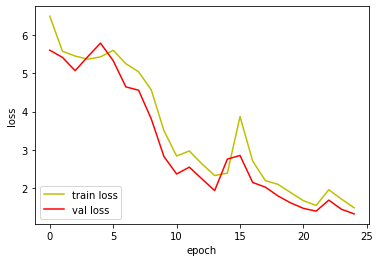

In [ ]:
# 5. 학습 과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

print('loss만 추출')
fig, loss_ax = plt.subplots()

loss_ax.plot(googlenet2_history.history['loss'],'y',label='train loss')
loss_ax.plot(googlenet2_history.history['val_loss'],'r',label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='lower left')
plt.show()

In [ ]:
# 6. 모델 평가하기
loss_and_metrics = googlenet.evaluate(X_test,y_test,batch_size=32)
#변수명 : X_train, X_test, y_train, y_test 
print('##### Test Result #####')
print('loss : ',str(loss_and_metrics[0]))
print('Accuracy : ',str(loss_and_metrics[1]))

# 7. 모델 저장하기
from tensorflow.python.keras.models import load_model
googlenet.save(f'{base_dir}/googlenet2_with_classifiers_88_test_220422.h5')

34/34 [==============================] - 7s 174ms/step - loss: 1.3373 - dense_8_loss: 0.8109 - dense_5_loss: 0.8922 - dense_7_loss: 0.8624 - dense_8_accuracy: 0.8121 - dense_5_accuracy: 0.8215 - dense_7_accuracy: 0.8187
##### Test Result #####
loss :  1.3372535705566406
Accuracy :  0.8108696341514587
